In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Read the CSV file into a DataFrame
files = {
    "Single Host": "result-single-host/test.csv",
    "Round Robin": "result-roundrobin/test.csv",
    "Least Connection": "result-leastconn/test.csv",
    "ollamaFlow": "result-ollamaflow/test.csv",
}
dfs = []
for source, file_path in files.items():
    df_temp = pd.read_csv(file_path)
    df_temp['source'] = source
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

In [9]:
# Convert the 'timestamp' column from Unix epoch to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [10]:
# Calculate elapsed time in minutes since the first timestamp
df['elapsed_seconds'] = (
    df.groupby('source')['timestamp']
      .transform(lambda x: (x - x.min()).dt.total_seconds())
)
df['elapsed_minutes'] = df['elapsed_seconds'] / 60.0

In [11]:
# Filter for 'http_req_waiting' metric and compute cumulative averages
df = df[df['metric_name'] == 'http_req_waiting']
df['metric_value_s'] = df['metric_value'] / 1000.0

df['cumulative_metric_average'] = (
    df.groupby('source')['metric_value']
      .expanding()
      .mean()
      .reset_index(level=0, drop=True)
)

df['cumulative_metric_average_s'] = (
    df.groupby('source')['metric_value_s']
      .expanding()
      .mean()
      .reset_index(level=0, drop=True)
)

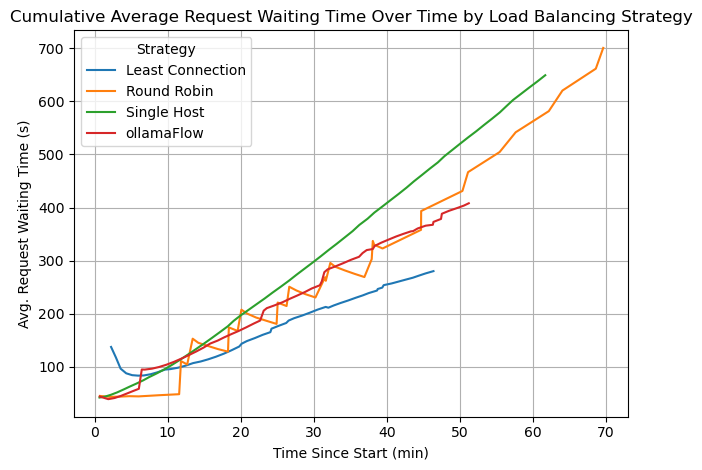

In [12]:
# Plot the cumulative average of 'http_req_waiting' over time
plt.figure()
for source, subset in df.groupby('source'):
    plt.plot(subset['elapsed_minutes'], subset['cumulative_metric_average_s'], label=source)

plt.xlabel('Time Since Start (min)')
plt.ylabel('Avg. Request Waiting Time (s)')
plt.title('Cumulative Average Request Waiting Time Over Time by Load Balancing Strategy')
plt.legend(title='Strategy')
plt.grid(True)
plt.tight_layout()
plt.show()